## **Project Title**: Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency



## Import Required Libraries

In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [4]:
# Load Libraries
import optuna
import joblib

from lightgbm import Booster
import numpy as np
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

import os
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Load Dataset

In [6]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv
sales_merge_dataset.csv


**Note:**
1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [ ]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [ ]:
# Check Sales dataset
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [ ]:
# Check DataFrame’s structure
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Insights:
* It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [ ]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

,0


Insights:
* There is not missing value in sales dataset

In [ ]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


**Note:**
* It is large dataset,so I will select one store & one product deppartment for my project


In [ ]:
# Check statistical Summary
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [ ]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [ ]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

,count
state_id,
CA,12196
TX,9147
WI,9147


In [ ]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

,count
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


In [ ]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

,count
cat_id,
FOODS,14370
HOUSEHOLD,10470
HOBBIES,5650


In [ ]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

,count
dept_id,
FOODS_3,8230
HOUSEHOLD_1,5320
HOUSEHOLD_2,5150
HOBBIES_1,4160
FOODS_2,3980
FOODS_1,2160
HOBBIES_2,1490


In [ ]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [ ]:
# Creating dataset with product selling minimum 10 per day(considering day 1)

sales_filtered = sales[sales['d_1']> 10]

In [ ]:
print(sales_filtered['state_id'].value_counts(),'\n')

print(sales_filtered['store_id'].value_counts(),'\n')

print(sales_filtered['cat_id'].value_counts(),'\n')

print(sales_filtered['dept_id'].value_counts(),'\n')

state_id
CA    268
WI    172
TX    145
Name: count, dtype: int64 

store_id
CA_3    91
CA_1    84
CA_2    82
WI_3    77
TX_2    67
WI_1    54
WI_2    41
TX_1    39
TX_3    39
CA_4    11
Name: count, dtype: int64 

cat_id
FOODS        449
HOBBIES       69
HOUSEHOLD     67
Name: count, dtype: int64 

dept_id
FOODS_3        349
FOODS_2         70
HOBBIES_1       69
HOUSEHOLD_1     65
FOODS_1         30
HOUSEHOLD_2      2
Name: count, dtype: int64 



In [ ]:
# Creating subset by filtering to state, store, category

sales_subset = sales_filtered[(sales_filtered["state_id"] == "WI") & (sales_filtered["store_id"] == "WI_3") & (sales_filtered["cat_id"] == "FOODS") & (sales_filtered["dept_id"] == "FOODS_2")]
sales_subset

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
29289,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,29,24,12,40,...,0,0,2,0,0,0,1,0,0,0
29395,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,13,8,19,8,...,7,4,5,5,3,8,2,2,5,3
29419,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,12,10,9,6,...,4,2,6,4,4,1,3,7,1,5
29431,FOODS_2_164_WI_3_validation,FOODS_2_164,FOODS_2,FOODS,WI_3,WI,12,10,12,7,...,6,15,4,0,2,0,2,9,3,2
29448,FOODS_2_181_WI_3_validation,FOODS_2_181,FOODS_2,FOODS,WI_3,WI,15,26,23,19,...,13,17,26,10,10,5,9,11,8,4
29500,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,12,6,4,8,...,6,7,5,3,1,6,8,5,3,4
29543,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,22,25,20,13,...,2,9,3,10,6,4,7,4,7,9
29627,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,26,22,18,3,...,27,16,11,12,6,19,25,17,14,6
29631,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,28,34,38,59,...,5,6,7,1,5,1,3,4,2,5
29665,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,11,15,12,14,...,8,16,7,5,3,18,5,9,3,4


In [ ]:
sales_subset.shape

(10, 1919)

In [ ]:
# Re-Check unique values in column except day column
for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 10
item_id: 10
dept_id: 1
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [ ]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12


In [ ]:
# Check data structure
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19130 non-null  object
 1   item_id   19130 non-null  object
 2   dept_id   19130 non-null  object
 3   cat_id    19130 non-null  object
 4   store_id  19130 non-null  object
 5   state_id  19130 non-null  object
 6   d         19130 non-null  object
 7   sales     19130 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [ ]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1


**Note:**

The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [ ]:
# Check calendar dataset
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Merge with calendar by "d" column that matches the "d" in sales_long
sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Check prices dataset
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98


**Note:**

If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [ ]:
# Check final columns  name
sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Basic overview with Final Dataset

In [ ]:
# Data structure of final dataset
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  1540 non-null   object 
 16  event_type_1  1540 non-null   object 
 17  event_name_2  40 non-null     object 
 18  event_type_2  40 non-null 

In [ ]:
sales_long.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


In [ ]:
# Check shape of our final dataset

sales_long.shape

(19130, 23)

In [ ]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0
event_name_1,17590
event_type_1,17590
event_name_2,19090
event_type_2,19090


In [ ]:
# Fill missing events with "No Event"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('No Event', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('No Event', inplace=True)

In [ ]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0


In [ ]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [ ]:
# Check filtered dataset
sales_long.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.43


In [ ]:
# Save final dataset

sales_long.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv', index=False)

## Load saved final dataset ( Store : WI_3, Dept : FOODS_2)

In [11]:
Sales_df = pd.read_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv')

## Basic overview

In [ ]:
# Show all columns

pd.set_option('display.max_columns', None)

In [ ]:
Sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,1.98


In [ ]:
Sales_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.43


In [ ]:
Sales_df.isnull().sum()

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
sales,0
day_number,0
date,0


In [ ]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  19130 non-null  object 
 16  event_type_1  19130 non-null  object 
 17  event_name_2  19130 non-null  object 
 18  event_type_2  19130 non-nu

In [ ]:
Sales_df.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


# Exploratory Data Analysis (EDA)

I will check sales patterns and price/promotion effects which are critical for demand forecasting and inventory optimization

## Target Variable Analysis (Sales)

### Sales distribution

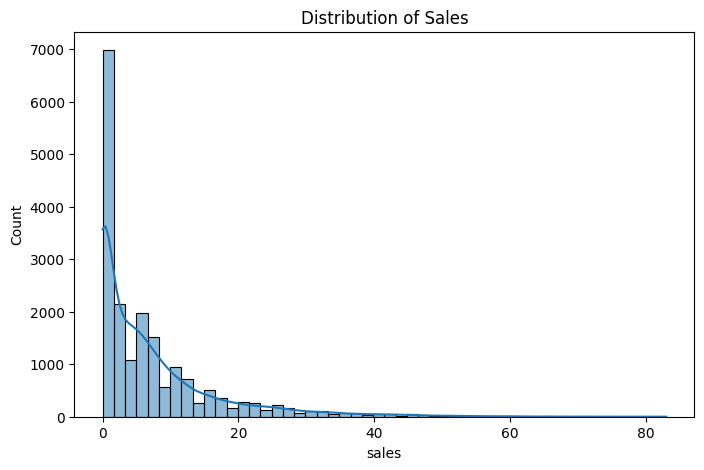

In [ ]:
# Distribution of sales
plt.figure(figsize=(8,5))
sns.histplot(Sales_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/distribution_of_sales.png")
plt.show()

### Zero-sales proportion (important for inventory risk)

In [ ]:
zero_ratio = (Sales_df['sales'] == 0).mean() * 100
print(f"Zero-sales days: {zero_ratio:.2f}%")


Zero-sales days: 31.90%


### Outlier detection

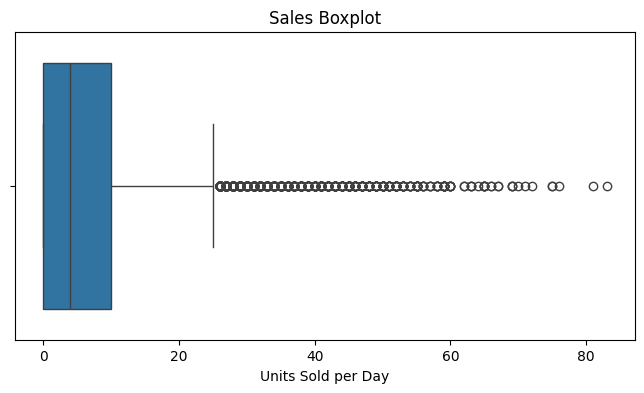

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sales', data=Sales_df)
plt.title('Sales Boxplot')
plt.xlabel('Units Sold per Day')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_boxplot.png")
plt.show()

## Time Series Behaviour (Trend & Seasonality)

Purpose: justify time-series and deep learning models.

### Convert date

In [ ]:
# Convert 'date' to datetime
Sales_df['date'] = pd.to_datetime(Sales_df['date'])

### Aggregate overall sales trend

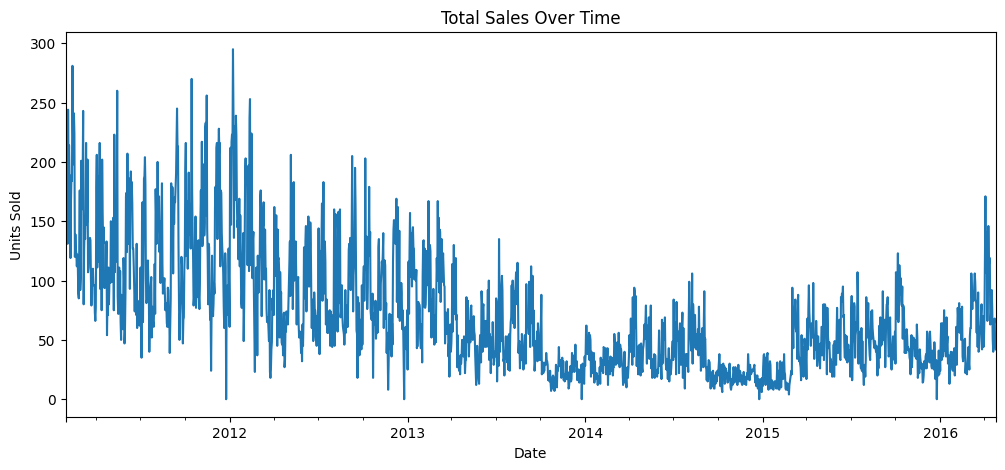

In [ ]:
# Aggregate sales by date and sort
daily_sales = Sales_df.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total_sales_over_time.png")
plt.show()

### Rolling mean (trend smoothing)

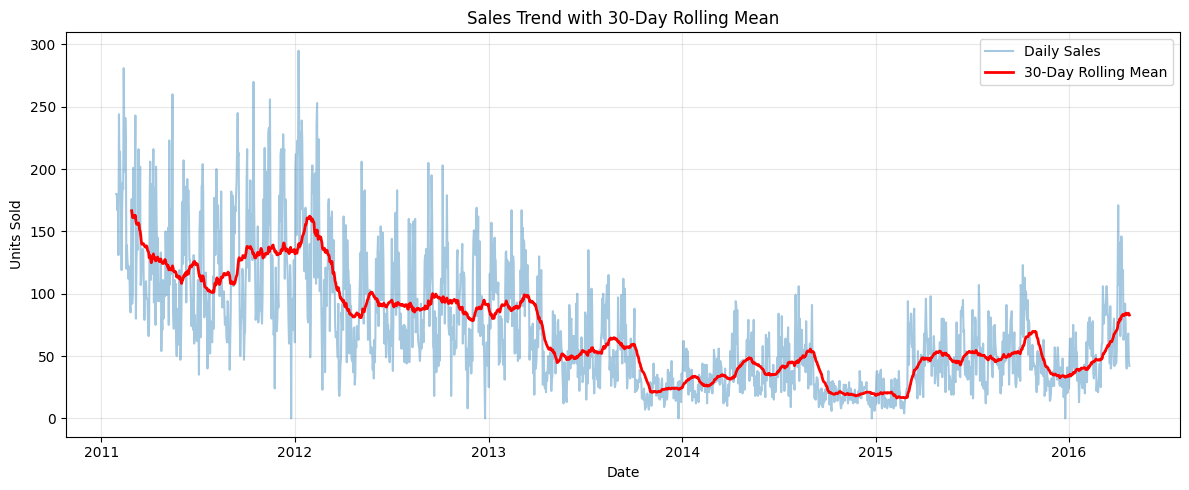

In [ ]:
rolling_30 = daily_sales.rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.4,label='Daily Sales')
plt.plot(rolling_30.index, rolling_30.values,linewidth=2, color='red',label='30-Day Rolling Mean')
plt.title('Sales Trend with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_trend_with_rolling_mean.png")
plt.tight_layout()
plt.show()

## Weekly & Yearly Seasonality

Purpose: justify seasonal parameters (e.g. 7-day seasonality).

In [ ]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

### Weekly pattern

In [ ]:
# Checking if weekday & number in same order

Weekday = {}
Weekday_number = {}

for i in Sales_df['wday'].unique():
  Weekday = Sales_df[Sales_df['wday']==i]['weekday'].unique()
  Weekday_number = i
  print(f"Weekday {Weekday_number}: {Weekday}")

Weekday 1: ['Saturday']
Weekday 2: ['Sunday']
Weekday 3: ['Monday']
Weekday 4: ['Tuesday']
Weekday 5: ['Wednesday']
Weekday 6: ['Thursday']
Weekday 7: ['Friday']


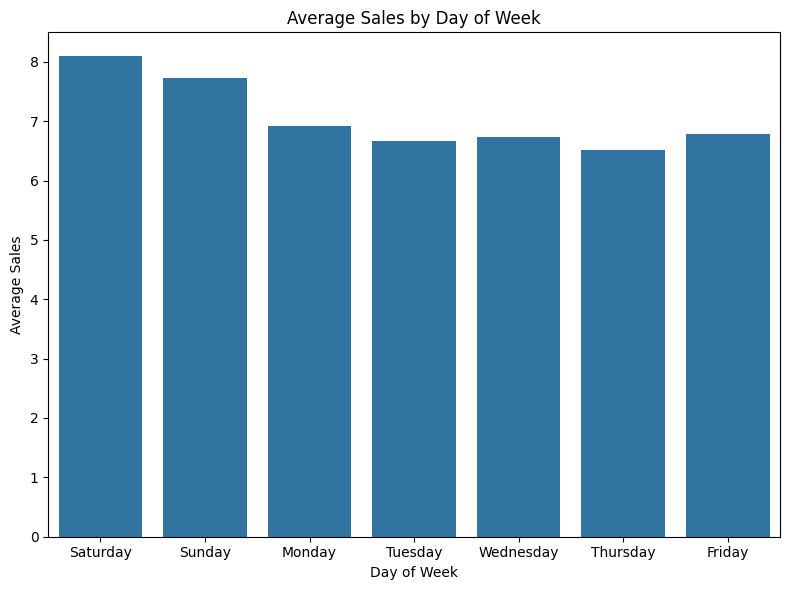

In [ ]:
weekly_pattern = Sales_df.groupby('weekday')['sales'].mean().reindex(Sales_df['weekday']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='sales', data=weekly_pattern)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by day of week.png")
plt.tight_layout()
plt.show()


### Monthly pattern

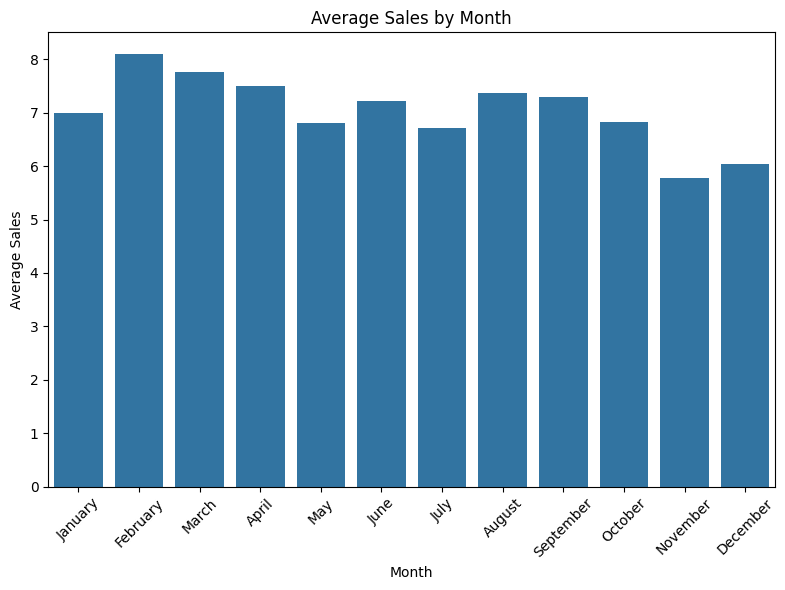

In [ ]:
Sales_df['month_name'] = Sales_df['date'].dt.month_name()

monthly_pattern = Sales_df.groupby('month_name')['sales'].mean().reindex(Sales_df['month_name']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_name', y='sales', data=monthly_pattern)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by month.png")
plt.tight_layout()
plt.show()


## Item level sales Behaviour

Purpose: show demand heterogeneity (important for inventory policy).

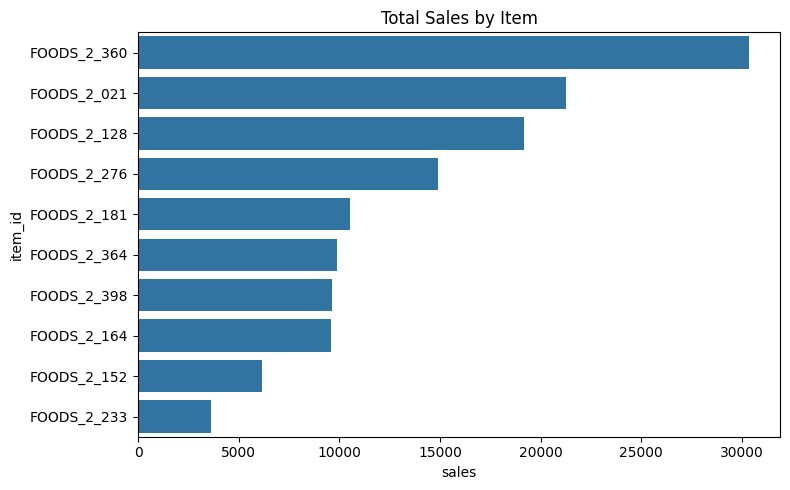

In [ ]:
store_sales = Sales_df.groupby('item_id')['sales'].sum().reset_index()

# Sort in descending order before plotting
store_sales = store_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='sales', y='item_id', data=store_sales)
plt.title('Total Sales by Item')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total sales by item.png")
plt.tight_layout()
plt.show()

## Price Effect Analysis
Purpose: connect demand forecasting with cost-based inventory decisions.

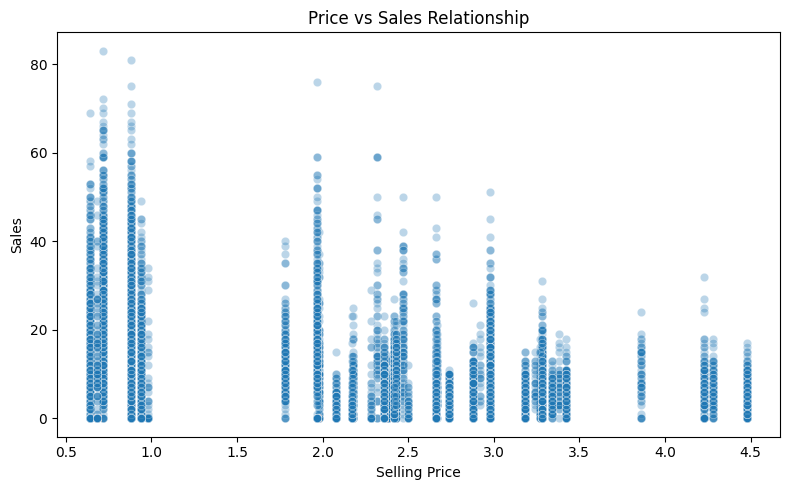

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='sell_price', y='sales', data=Sales_df, alpha=0.3)
plt.title('Price vs Sales Relationship')
plt.xlabel('Selling Price')
plt.ylabel('Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/price vs sales relationship.png")
plt.tight_layout()
plt.show()


## Promotion & Event Impact
Purpose: justify exogenous variables.

### SNAP effect

In [ ]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'month_name'],
      dtype='object')

In [ ]:
Sales_df['snap_WI'].unique()

array([0, 1])

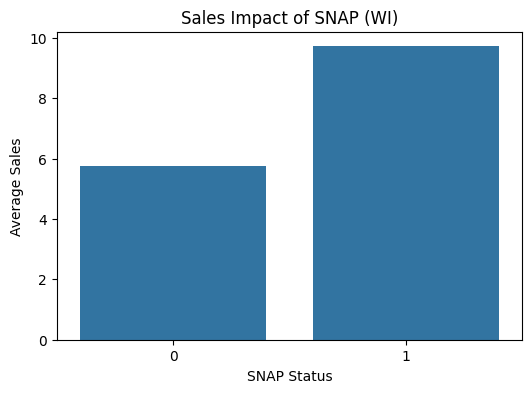

In [ ]:
snap_effect = Sales_df.groupby('snap_WI')['sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='snap_WI', y='sales', data=snap_effect)
plt.title('Sales Impact of SNAP (WI)')
plt.xlabel('SNAP Status')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales impact of snap (WI).png")
plt.show()


In [ ]:
Sales_df['event_type_1'].unique()

array(['No Event', 'Sporting', 'Cultural', 'National', 'Religious'],
      dtype=object)

In [ ]:
Sales_df['event_name_1'].unique()

array(['No Event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [ ]:
Sales_df['event_type_2'].unique()

array(['No Event', 'Cultural', 'Religious'], dtype=object)

In [ ]:
Sales_df['event_name_2'].unique()

array(['No Event', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster',
       "Father's day"], dtype=object)

### Events Effect

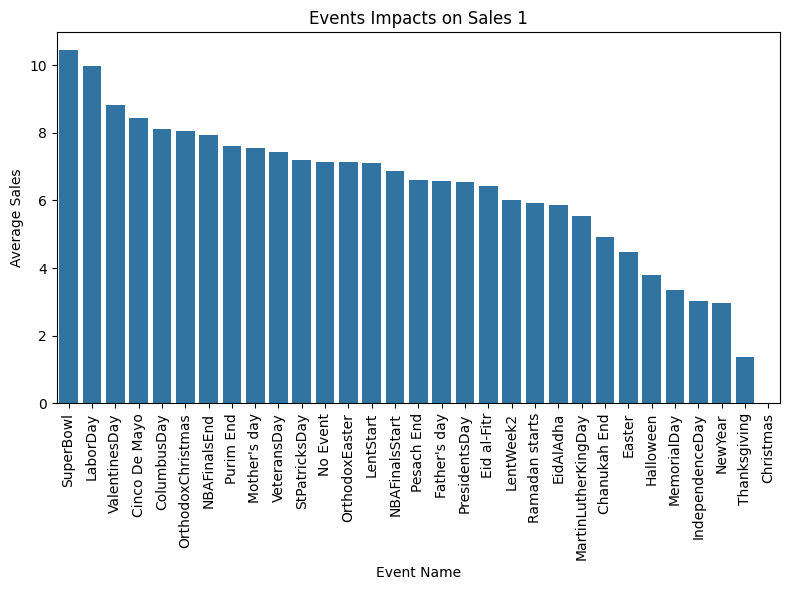

In [ ]:
event_sales = Sales_df.groupby('event_name_1')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_1', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 1')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 1.png")
plt.tight_layout()
plt.show()


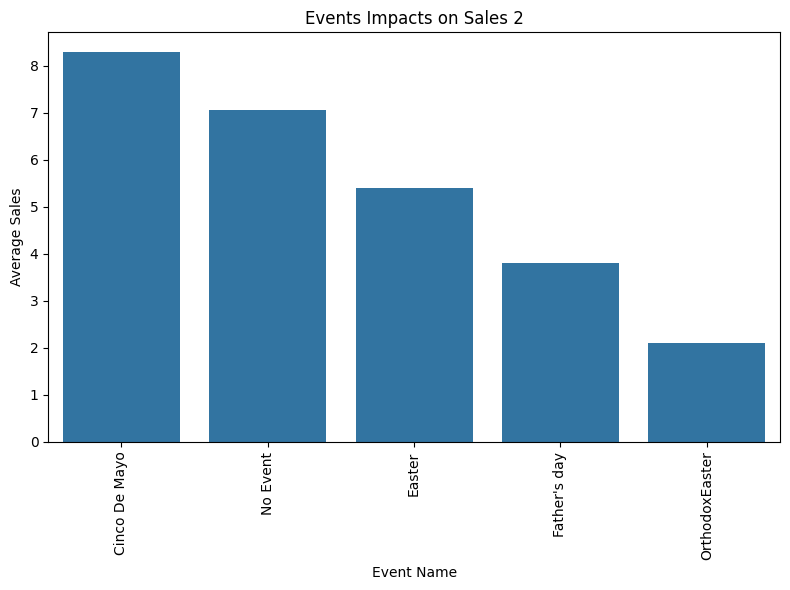

In [ ]:
event_sales = Sales_df.groupby('event_name_2')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_2', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 2')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 2.png")
plt.tight_layout()
plt.show()

##Correlation Analysis (Numerical Features)

Purpose: feature selection justification.

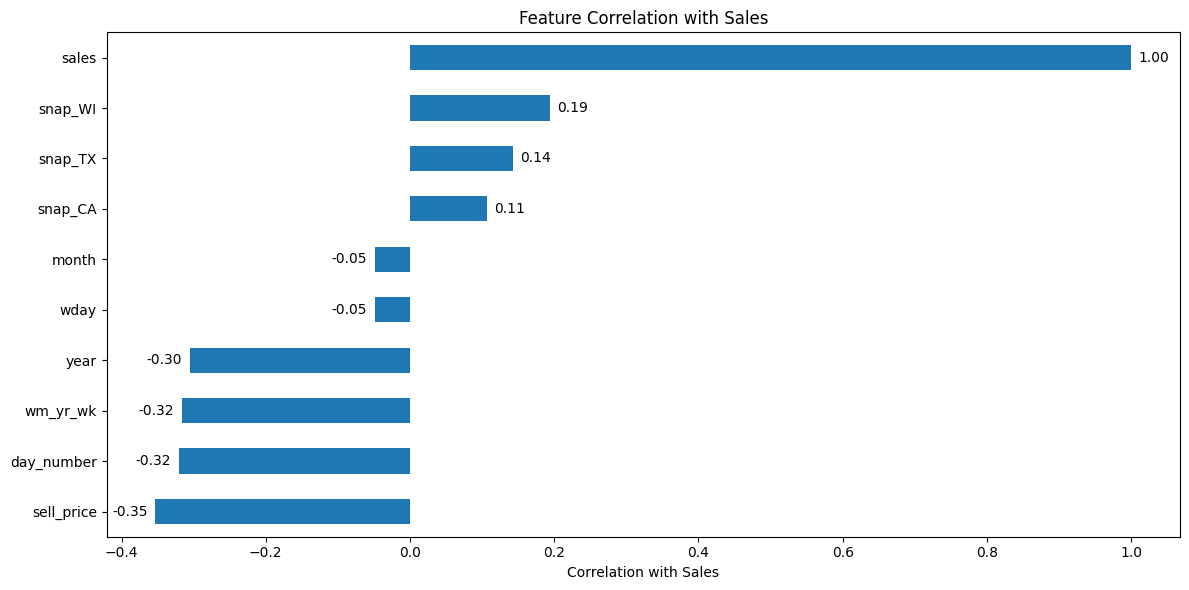

In [ ]:
num_cols = ['sales','sell_price','day_number','wm_yr_wk','wday','month','year','snap_CA','snap_TX','snap_WI']
corr_with_sales = sales_long[num_cols].corr()['sales'].sort_values()

plt.figure(figsize=(12,6))
ax = corr_with_sales.plot(kind='barh')

# Add value labels
for i, v in enumerate(corr_with_sales):
    ax.text(
        v + 0.01 if v > 0 else v - 0.06,  # position
        i,
        f"{v:.2f}",
        va='center'
    )

plt.xlabel('Correlation with Sales')
plt.title('Feature Correlation with Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/feature_correlation_with_sales.png")
plt.tight_layout()
plt.show()

## Data Preprocessing

### Date & Sorting

In [ ]:
Sales_df['date'] = pd.to_datetime(Sales_df['date'])
Sales_df = Sales_df.sort_values(['item_id', 'date'])

## Gradient Boosting model

In [ ]:
df_gb = Sales_df.copy()

In [ ]:
# Feature engineering (MANDATORY for ML forecasting)
LAGS = [1, 7, 14, 28]

for lag in LAGS:
    df_gb[f"sales_lag_{lag}"] = df_gb.groupby(
        ["item_id"]
    )["sales"].shift(lag)

df_gb["rolling_mean_7"] = df_gb.groupby(
    ["item_id"]
)["sales"].shift(1).rolling(7).mean()

df_gb["rolling_mean_28"] = df_gb.groupby(
    ["item_id"]
)["sales"].shift(1).rolling(28).mean()

df_gb = df_gb.dropna().reset_index(drop=True)


In [ ]:
# Define target & features
TARGET = "sales"

FEATURES = [
    "day_number", "wday", "month", "year",
    "snap_CA", "snap_TX", "snap_WI",
    "sell_price",
    "sales_lag_1", "sales_lag_7", "sales_lag_14", "sales_lag_28",
    "rolling_mean_7", "rolling_mean_28",
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]


In [ ]:
# XGBoost, LightGBM need encoding
df_gb_encoding = df_gb.copy()

# CatBoost handles categoricals natively → no encoding needed
df_gb_nonencoding = df_gb.copy()

In [ ]:
# Encode categorical variables

cat_cols = [
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_gb_encoding[col] = le.fit_transform(df_gb_encoding[col])
    label_encoders[col] = le


In [ ]:
# Train Test spliting for LightGBM,  XGBoost
split_idx = int(len(df_gb_encoding) * 0.8)

train__en = df_gb_encoding.iloc[:split_idx]
valid__en = df_gb_encoding.iloc[split_idx:]

X_train_en = train__en[FEATURES]
y_train_en = train__en[TARGET]

X_valid_en = valid__en[FEATURES]
y_valid_en = valid__en[TARGET]


In [ ]:
# Train Test spliting for CatBoosting
split_idx = int(len(df_gb_nonencoding) * 0.8)

train_nonen = df_gb_nonencoding.iloc[:split_idx]
valid_nonen = df_gb_nonencoding.iloc[split_idx:]

X_train_nonen = train_nonen[FEATURES]
y_train_nonen = train_nonen[TARGET]

X_valid_nonen = valid_nonen[FEATURES]
y_valid_nonen = valid_nonen[TARGET]

In [ ]:
#  Evaluation metrics
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return rmse, mae, mape, smape


## Models Building

### XGBoost

In [ ]:
'''xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train_en, y_train_en)'''

joblib.dump(xgb, "/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl")

['/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl']

In [ ]:
xgb_loaded = joblib.load("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl")
xgb_preds = xgb_loaded.predict(X_valid_en)
xgb_scores = evaluate(y_valid_en, xgb_preds)
print(xgb_scores)

(np.float64(4.977664460205564), 3.92332124710083, np.float64(193.62240033960418), np.float64(90.32991384401706))


### LightGBM

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train_en, y_train_en)

lgbm.booster_.save_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/lgbm_model.txt")

In [ ]:
loaded_booster = Booster(model_file="/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/lgbm_model.txt")

lgbm_preds = loaded_booster.predict(X_valid_en.values)

lgbm_scores = evaluate(y_valid_en, lgbm_preds)
print(lgbm_scores)

(np.float64(4.7511507295837925), 3.64767002488033, np.float64(171.77806832180488), np.float64(88.66118874449323))


### CatBoost

In [ ]:
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    verbose=50,
    random_seed=42
)

cb.fit(
    X_train_nonen,
    y_train_nonen,
    cat_features=cat_cols
)

cb.save_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model.cbm")

In [ ]:
cb_loaded = CatBoostRegressor()
cb_loaded.load_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model.cbm")

cb_preds = cb_loaded.predict(X_valid_nonen)
cb_scores = evaluate(y_valid_nonen, cb_preds)
print(cb_scores)

(np.float64(3.5684634994537885), 2.5319174467442602, np.float64(100.963506481483), np.float64(81.61185216247448))


In [ ]:
results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "RMSE": [xgb_scores[0], lgbm_scores[0], cb_scores[0]],
    "MAE": [xgb_scores[1], lgbm_scores[1], cb_scores[1]],
    "MAPE (%)": [xgb_scores[2], lgbm_scores[2], cb_scores[2]],
    "sMAPE (%)": [xgb_scores[3], lgbm_scores[3], cb_scores[3]]
})

results.sort_values("RMSE")



,Model,RMSE,MAE,MAPE (%),sMAPE (%)
2,CatBoost,3.568463,2.531917,100.963506,81.611852
1,LightGBM,4.751151,3.647670,171.778068,88.661189
0,XGBoost,4.977664,3.923321,193.622400,90.329914


In [ ]:
results.keys()

Index(['Model', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)'], dtype='object')

## Holt-Winters Model

In [ ]:
df_holt_winters = Sales_df.copy()

# Containers
forecast_hw = []
actual_hw = []
eval_hw = []

# Unique items
items_hw = df_holt_winters['item_id'].unique()

# Evaluation function (same as CatBoost pipeline)
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return rmse, mae, mape, smape

for item in items_hw:
    # Prepare time series
    ts = df_holt_winters[df_holt_winters['item_id'] == item].sort_values('date').set_index('date')['sales']

    # Optional: log transform
    ts_log = np.log1p(ts)

    # Train/test split (last 28 days)
    train, test = ts_log[:-28], ts_log[-28:]

    # Fit Holt-Winters
    model_hw = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # Forecast next 28 days
    forecast_log = model_hw.forecast(28)

    # Inverse transform
    forecast = np.expm1(forecast_log)
    actual = np.expm1(test)

    # Store forecasts
    forecast_df = forecast.to_frame(name=item).T
    forecast_df.columns = forecast.index
    forecast_hw.append(forecast_df)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    actual_hw.append(actual_df)

    # Evaluate using same metrics as CatBoost
    rmse, mae, mape, smape = evaluate(actual, forecast)
    eval_hw.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final output tables
hw_forecast_df = pd.concat(forecast_hw).reset_index(drop=True)
hw_actual_df = pd.concat(actual_hw).reset_index(drop=True)
hw_eval_df = pd.DataFrame(eval_hw).reset_index(drop=True)

# Display evaluation metrics
print(hw_eval_df.head())


       item_id      RMSE       MAE    MAPE (%)   sMAPE (%)
0  FOODS_2_021  6.806383  5.860631  302.927806  113.733688
1  FOODS_2_128  6.090465  4.298915   61.162953   67.445195
2  FOODS_2_152  1.839420  1.504159   56.676084   42.819986
3  FOODS_2_164  4.567387  3.299101   74.409249   70.621442
4  FOODS_2_181  9.532621  7.193747   49.013837   61.287648


## Holt Winter Model Evaluation (Average across items)

In [ ]:
overall_hw_metrics = hw_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()

print("Holt-Winters Overall Performance:\n")
overall_hw_metrics.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_hw_metrics'.csv")
overall_hw = pd.DataFrame({
    "Model": ["Holt-Winters"],
    "RMSE": [overall_hw_metrics["RMSE"]],
    "MAE": [overall_hw_metrics["MAE"]],
    "MAPE (%)": [overall_hw_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_hw_metrics["sMAPE (%)"]]
})

overall_hw

Holt-Winters Overall Performance:



,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,Holt-Winters,6.144599,4.73881,83.105763,74.126878


## Visualization Forecast vs Actual (Based on one single item)

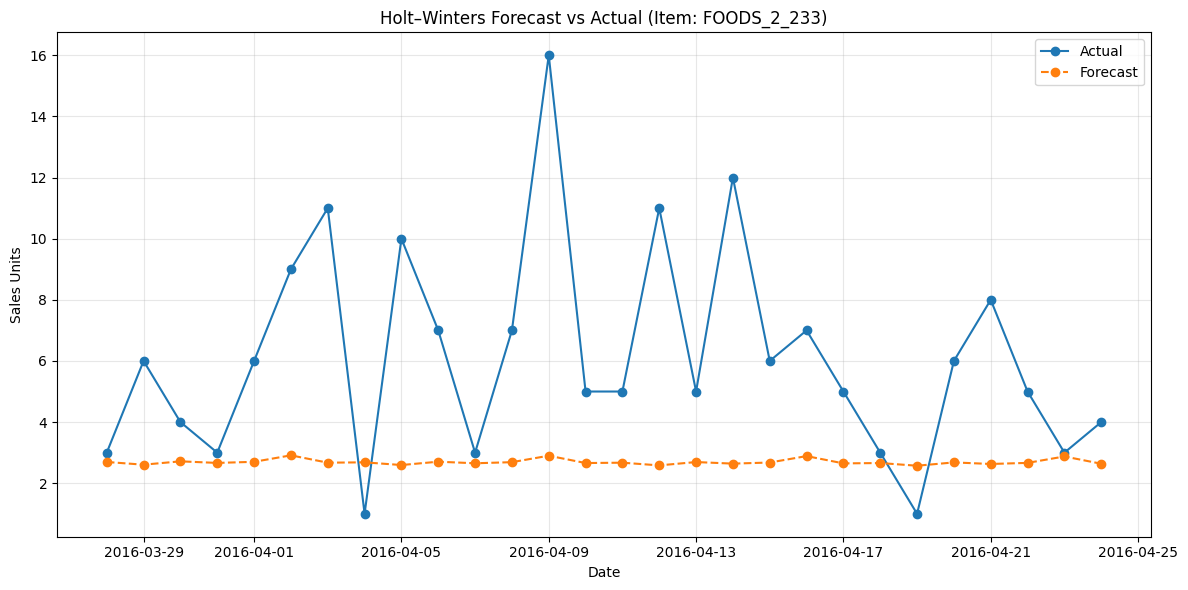

In [ ]:
example_item = hw_forecast_df.index[5]

dates = hw_actual_df.loc[example_item].index  # forecast horizon dates

plt.figure(figsize=(12,6))
plt.plot(dates, hw_actual_df.loc[example_item].values, marker='o', label='Actual')
plt.plot(dates, hw_forecast_df.loc[example_item].values, marker='o', linestyle='--', label='Forecast')

plt.title(f'Holt–Winters Forecast vs Actual (Item: {example_item})')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Holt-Winters Forecast vs Actual.png")
plt.tight_layout()
plt.show()


##SARIMA Model

In [ ]:
df_sarima = Sales_df.copy()
# Containers
forecast_sarima = []
actual_sarima = []
eval_sarima = []

# Unique items
items_sarima = df_sarima['item_id'].unique()

# Evaluation function (same as CatBoost pipeline)
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return rmse, mae, mape, smape

for item in items_sarima:
    # Prepare time series
    ts = df_sarima[df_sarima['item_id'] == item].sort_values('date').set_index('date')['sales']

    # Optional: log transform to handle skewness
    ts_log = np.log1p(ts)

    # Train/test split (last 28 days)
    train, test = ts_log[:-28], ts_log[-28:]

    # Fit SARIMA model
    model_sarima = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast next 28 days
    forecast_log = model_sarima.forecast(28)

    # Inverse log transform
    forecast = np.expm1(forecast_log)
    actual = np.expm1(test)

    # Store forecasts and actuals
    forecast_df = forecast.to_frame(name=item).T
    forecast_df.columns = forecast.index
    forecast_sarima.append(forecast_df)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    actual_sarima.append(actual_df)

    # Evaluate using same metrics
    rmse, mae, mape, smape = evaluate(actual, forecast)
    eval_sarima.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final tables
sarima_forecast_df = pd.concat(forecast_sarima).reset_index(drop=True)
sarima_actual_df = pd.concat(actual_sarima).reset_index(drop=True)
sarima_eval_df = pd.DataFrame(eval_sarima).reset_index(drop=True)

# Display first rows of evaluation
sarima_eval_df


,item_id,RMSE,MAE,MAPE (%),sMAPE (%)
0,FOODS_2_021,6.819719,5.860931,286.045212,115.980108
1,FOODS_2_128,6.093243,4.302211,61.188338,67.521521
2,FOODS_2_152,2.021201,1.631425,51.041353,46.927001
3,FOODS_2_164,4.524465,3.263317,74.789845,69.565187
4,FOODS_2_181,9.291531,6.964611,48.363041,58.569999
5,FOODS_2_233,4.521386,3.359991,55.101973,62.529609
6,FOODS_2_276,4.140339,3.406972,62.177945,71.198394
7,FOODS_2_360,13.649053,10.089889,41.696928,48.181841
8,FOODS_2_364,3.715869,3.192953,76.319614,135.402691
9,FOODS_2_398,6.331132,4.895852,48.284717,54.482998


## Sarima Model Evaluation (Average across items)

In [ ]:
# Overall Metrics
overall_sarima_metrics = sarima_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()
overall_sarima_metrics.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_sarima_metrics.csv")
overall_sarima = pd.DataFrame({
    "Model": ["Sarima"],
    "RMSE": [overall_sarima_metrics["RMSE"]],
    "MAE": [overall_sarima_metrics["MAE"]],
    "MAPE (%)": [overall_sarima_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_sarima_metrics["sMAPE (%)"]]
})

overall_sarima

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,Sarima,6.110794,4.696815,80.500897,73.035935


## Visualization Forecast vs Actual (Based on one single item)

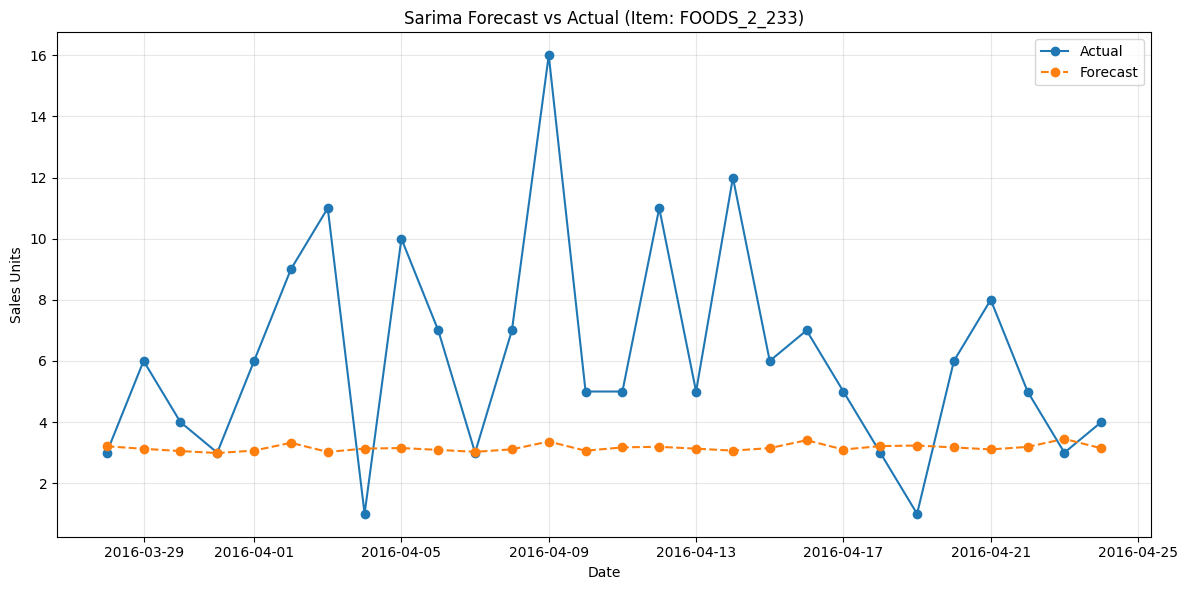

In [ ]:
example_item = sarima_forecast_df.index[5]

dates = sarima_actual_df.loc[example_item].index  # forecast horizon dates

plt.figure(figsize=(12,6))
plt.plot(dates, sarima_actual_df.loc[example_item].values, marker='o', label='Actual')
plt.plot(dates, sarima_forecast_df.loc[example_item].values, marker='o', linestyle='--', label='Forecast')

plt.title(f'Sarima Forecast vs Actual (Item: {example_item})')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Sarima Forecast vs Actual.png")
plt.tight_layout()
plt.show()

###  LSTM Model

In [ ]:
df_lstm = Sales_df.copy()

# Containers
lstm_forecast = []
lstm_actual = []
lstm_eval = []

# Sequence generation function
def create_sequences(data, window_size=28):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Evaluation function (same as CatBoost pipeline)
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return rmse, mae, mape, smape

# Unique items
items_lstm = df_lstm['item_id'].unique()

for item in items_lstm:
    ts = df_lstm[df_lstm['item_id']==item].sort_values('date')
    ts = ts.set_index('date')['sales'].values.reshape(-1,1)

    # Log transform
    ts = np.log1p(ts)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts)

    # Train/validation split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1],1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')

    # Train
    history  = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model_lstm.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Inverse log transform
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)

    # Store forecast & actual
    forecast_df = pd.DataFrame([y_pred.flatten()], columns=range(1, len(y_pred)+1), index=[item])
    actual_df = pd.DataFrame([y_true.flatten()], columns=range(1, len(y_true)+1), index=[item])
    lstm_forecast.append(forecast_df)
    lstm_actual.append(actual_df)

    # Evaluate
    rmse, mae, mape, smape = evaluate(y_true, y_pred)
    lstm_eval.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final tables
lstm_forecast_table = pd.concat(lstm_forecast).reset_index(drop=True)
lstm_actual_table = pd.concat(lstm_actual).reset_index(drop=True)
lstm_eval_df = pd.DataFrame(lstm_eval).reset_index(drop=True)

# Display evaluation
print(lstm_eval_df.head())


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
       item_id      RMSE       MAE   MAPE (%)   sMAPE (%)
0  FOODS_2_021  4.198978  2.548283  81.215346  117.962740
1  FOODS_2_128  3.890004  2.327398  73.827454  114.121493
2  FOODS_2_152  2.337874  1.644161  72.317606   92.552793
3  FOODS_2_164  3.011037  2.253808  91.446065   81.508086
4  FOODS_2_181  4.953638  2.901711  35.311969  103.931551


##  LSTM Loss

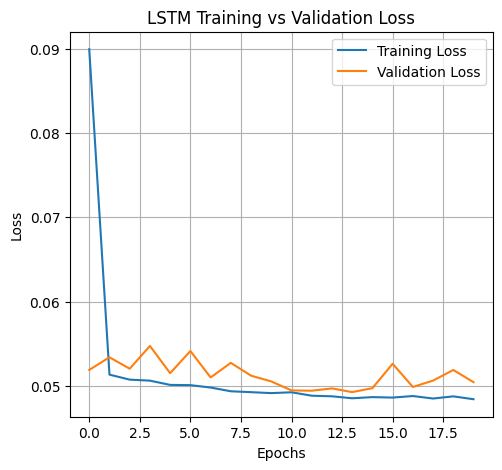

In [ ]:
# Create Figure
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/LSTM Loss.png")
plt.show()

## LSTM Model Evaluation (Average across items)

In [ ]:
overall_lstm_metrics = lstm_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()
overall_lstm_metrics.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_lstm_metrics.csv')
overall_lstm = pd.DataFrame({
    "Model": ["LSTM"],
    "RMSE": [overall_lstm_metrics["RMSE"]],
    "MAE": [overall_lstm_metrics["MAE"]],
    "MAPE (%)": [overall_lstm_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_lstm_metrics["sMAPE (%)"]]
})

overall_lstm

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,LSTM,3.96741,2.665839,70.283243,91.252426


In [ ]:
all_models_overall = pd.concat([results, overall_hw,overall_sarima,overall_lstm])

# Sort by RMSE or sMAPE if desired
all_models_overall = all_models_overall.sort_values("RMSE").reset_index(drop=True)

all_models_overall

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,CatBoost,3.568463,2.531917,100.963506,81.611852
1,LSTM,3.967410,2.665839,70.283243,91.252426
2,LightGBM,4.751151,3.647670,171.778068,88.661189
3,XGBoost,4.977664,3.923321,193.622400,90.329914
4,Sarima,6.110794,4.696815,80.500897,73.035935
5,Holt-Winters,6.144599,4.738810,83.105763,74.126878


In [ ]:
# Your results table
results = all_models_overall

# Rank each metric (1 = best)
results['RMSE_rank'] = results['RMSE'].rank(method='min')
results['MAE_rank'] = results['MAE'].rank(method='min')
results['MAPE_rank'] = results['MAPE (%)'].rank(method='min')
results['sMAPE_rank'] = results['sMAPE (%)'].rank(method='min')

# Compute overall score (sum of ranks; lower = better)
results['Overall_rank'] = results[['RMSE_rank','MAE_rank','MAPE_rank','sMAPE_rank']].sum(axis=1)

# Sort by overall rank
results_sorted = results.sort_values('Overall_rank').reset_index(drop=True)

results_sorted


,Model,RMSE,MAE,MAPE (%),sMAPE (%),RMSE_rank,MAE_rank,MAPE_rank,sMAPE_rank,Overall_rank
0,CatBoost,3.568463,2.531917,100.963506,81.611852,1.0,1.0,4.0,3.0,9.0
1,LSTM,3.967410,2.665839,70.283243,91.252426,2.0,2.0,1.0,6.0,11.0
2,Sarima,6.110794,4.696815,80.500897,73.035935,5.0,5.0,2.0,1.0,13.0
3,LightGBM,4.751151,3.647670,171.778068,88.661189,3.0,3.0,5.0,4.0,15.0
4,Holt-Winters,6.144599,4.738810,83.105763,74.126878,6.0,6.0,3.0,2.0,17.0
5,XGBoost,4.977664,3.923321,193.622400,90.329914,4.0,4.0,6.0,5.0,19.0


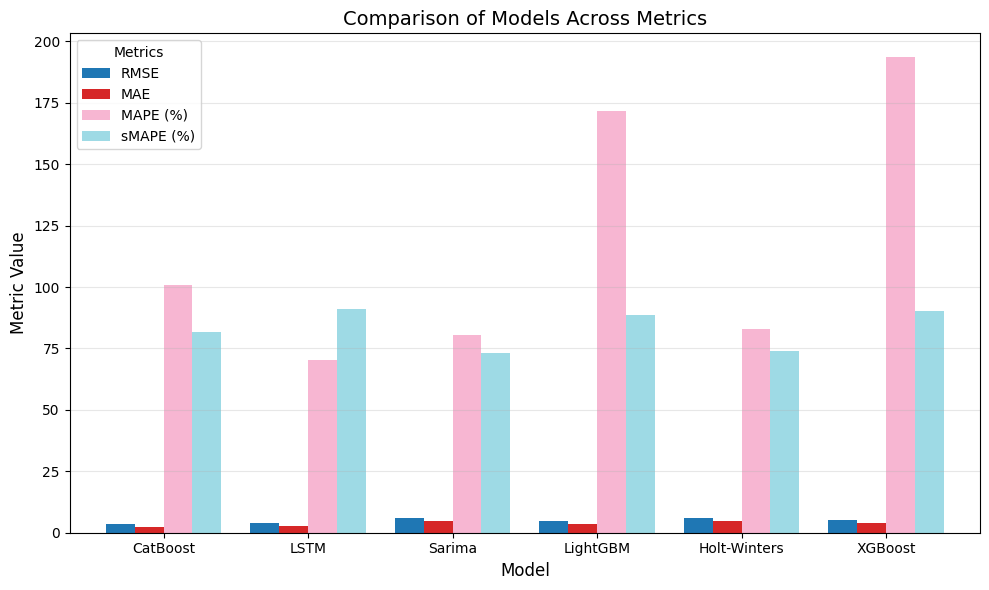

In [ ]:
# Select only the metrics for plotting
df_plot = results_sorted.set_index('Model')[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']]

# Create grouped bar chart
ax = df_plot.plot(kind='bar', figsize=(10,6), width=0.8, colormap='tab20')

# Formatting
plt.title('Comparison of Models Across Metrics', fontsize=14)
plt.ylabel('Metric Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metrics')
plt.tight_layout()

# Save figure
plt.savefig(
    '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Model_Comparison_BarChart.png',
    dpi=300
)

plt.show()


## Visualization Forecast vs Actual (Based on one single item)

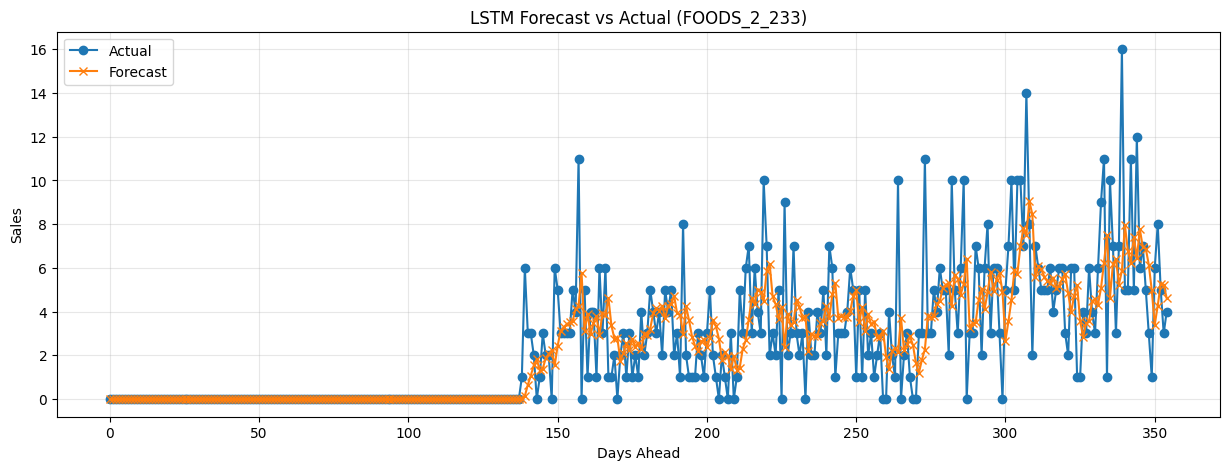

In [ ]:
example_item = lstm_forecast_table.index[5]

plt.figure(figsize=(15,5))
plt.plot(lstm_actual_table.loc[example_item].values, label='Actual', marker='o')
plt.plot(lstm_forecast_table.loc[example_item].values, label='Forecast', marker='x')
plt.title(f'LSTM Forecast vs Actual ({example_item})')
plt.xlabel('Days Ahead')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/LSTM Forecast vs Actual.png")
plt.show()


## Hyperparameter Tuning

In [ ]:
def objective(trial, X_train, y_train, X_val, y_val, scaler):
    # Suggest hyperparameters
    units = trial.suggest_int("units", 32, 128, step=32)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # Build LSTM
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    # Predict
    y_pred_scaled = model.predict(X_val)
    y_true = scaler.inverse_transform(y_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)

    # Evaluate with RMSE + sMAPE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

    return rmse + smape


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, scaler), n_trials=20)

best_params = study.best_params


[I 2025-12-19 01:41:13,660] A new study created in memory with name: no-name-133a9e16-0861-4804-b0f7-7ffa49a05acd


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-12-19 01:41:53,453] Trial 0 finished with value: 70.02543255807855 and parameters: {'units': 96, 'activation': 'relu', 'lr': 0.002562668679358386}. Best is trial 0 with value: 70.02543255807855.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-12-19 01:42:38,502] Trial 1 finished with value: 67.87589095052462 and parameters: {'units': 64, 'activation': 'relu', 'lr': 0.0017468732225519499}. Best is trial 1 with value: 67.87589095052462.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-12-19 01:43:12,365] Trial 2 finished with value: 67.93131554239625 and parameters: {'units': 64, 'activation': 'tanh', 'lr': 0.0005333072998752305}. Best is trial 1 with value: 67.87589095052462.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-12-19 01:43:30,827] Trial 3 finished with value: 69.29373942497666 and parameters: {'units': 64, 'activation': 'tanh', 'lr': 0.0002349963939110504}. Best is trial 1 with value: 67.87589095052462.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-12-19 01:43:52,490] Trial 4 finished with value: 66.1953512796174 and parameters: {'units': 96, 'activation': 'tanh', 'lr': 0.0028386684442646463}. Best is trial 4 with value: 66.1953512796174.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


[I 2025-12-19 01:44:02,974] Trial 5 finished with value: 66.90326215967681 and parameters: {'units': 32, 'activation': 'relu', 'lr': 0.008625082356882096}. Best is trial 4 with value: 66.1953512796174.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-12-19 01:44:41,380] Trial 6 finished with value: 66.87065937247615 and parameters: {'units': 128, 'activation': 'relu', 'lr': 0.0011724533130699898}. Best is trial 4 with value: 66.1953512796174.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-12-19 01:44:55,238] Trial 7 finished with value: 68.2212045045645 and parameters: {'units': 96, 'activation': 'relu', 'lr': 0.004525747657644541}. Best is trial 4 with value: 66.1953512796174.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-12-19 01:45:21,957] Trial 8 finished with value: 66.94678499473065 and parameters: {'units': 64, 'activation': 'relu', 'lr': 0.0017592825213668492}. Best is trial 4 with value: 66.1953512796174.


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


[I 2025-12-19 01:46:44,601] Trial 9 finished with value: 66.04650885270583 and parameters: {'units': 128, 'activation': 'relu', 'lr': 0.0009423439242919529}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-12-19 01:48:23,199] Trial 10 finished with value: 69.68027631621152 and parameters: {'units': 128, 'activation': 'tanh', 'lr': 0.00010258977654650546}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


[I 2025-12-19 01:49:46,684] Trial 11 finished with value: 67.89929365716529 and parameters: {'units': 128, 'activation': 'tanh', 'lr': 0.0004919708536226028}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-12-19 01:50:59,937] Trial 12 finished with value: 68.33625259238993 and parameters: {'units': 96, 'activation': 'tanh', 'lr': 0.0006505836945329349}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-12-19 01:51:54,402] Trial 13 finished with value: 66.56890028559678 and parameters: {'units': 128, 'activation': 'tanh', 'lr': 0.003790758094972013}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2025-12-19 01:52:12,351] Trial 14 finished with value: 70.55533462399767 and parameters: {'units': 96, 'activation': 'relu', 'lr': 0.00945413682217778}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-12-19 01:52:45,559] Trial 15 finished with value: 67.75036698071428 and parameters: {'units': 128, 'activation': 'tanh', 'lr': 0.0009349049321781286}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-12-19 01:53:12,949] Trial 16 finished with value: 69.21246656898558 and parameters: {'units': 96, 'activation': 'tanh', 'lr': 0.0003446715704937361}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-12-19 01:53:32,837] Trial 17 finished with value: 67.01328564773031 and parameters: {'units': 32, 'activation': 'relu', 'lr': 0.004686783718493457}. Best is trial 9 with value: 66.04650885270583.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-12-19 01:55:02,832] Trial 18 finished with value: 65.33190688753719 and parameters: {'units': 128, 'activation': 'relu', 'lr': 0.0012994326613713593}. Best is trial 18 with value: 65.33190688753719.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2025-12-19 01:55:50,919] Trial 19 finished with value: 67.60174801106228 and parameters: {'units': 128, 'activation': 'relu', 'lr': 0.001214241577118584}. Best is trial 18 with value: 65.33190688753719.


In [ ]:
import json

# Save best params to a JSON file
with open("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/best_lstm_params.json", "w") as f:
    json.dump(best_params, f)


In [ ]:
import json

with open("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/best_lstm_params.json", "r") as f:
    best_params = json.load(f)

print(best_params)
Best_params = pd.DataFrame(best_params, index=[0])
Best_params

{'units': 128, 'activation': 'relu', 'lr': 0.0012994326613713593}


,units,activation,lr
0,128,relu,0.001299


## Re Train LSTM Model by tuned Parameter

In [ ]:
df_lstm = Sales_df.copy()

# Containers
lstm_forecast_tuned = []
lstm_actual_tuned = []
lstm_eval_tuned = []

# Unique items
items_lstm = df_lstm['item_id'].unique()

for item in items_lstm:
    ts = df_lstm[df_lstm['item_id'] == item].sort_values('date')
    ts_values = ts.set_index('date')['sales'].values.reshape(-1, 1)

    # Log transform
    ts_log = np.log1p(ts_values)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts_log)

    # Train/validation split
    train_size = int(len(ts_scaled) * 0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build LSTM model
    model_lstm_tuned = Sequential()
    model_lstm_tuned.add(LSTM(best_params['units'], activation=best_params['activation'],
                              input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm_tuned.add(Dense(1))
    model_lstm_tuned.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    model_lstm_tuned.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # Predict on validation set for evaluation
    y_val_pred_scaled = model_lstm_tuned.predict(X_val)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler.inverse_transform(y_val)

    y_val_pred = np.expm1(y_val_pred)
    y_val_true = np.expm1(y_val_true)

    # Store actuals for validation period
    actual_df = pd.DataFrame([y_val_true.flatten()], columns=range(1, len(y_val_true)+1), index=[item])
    lstm_actual_tuned.append(actual_df)

    # Evaluate
    rmse, mae, mape, smape = evaluate(y_val_true, y_val_pred)
    lstm_eval_tuned.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

    # Generate 28-day forecast
    last_sequence = ts_scaled[-X_train.shape[1]:].reshape(1, X_train.shape[1], 1)
    forecast_28 = []
    for _ in range(28):
        y_pred_scaled = model_lstm_tuned.predict(last_sequence)
        forecast_28.append(y_pred_scaled[0, 0])
        # Make y_pred_scaled 3D for concatenation
        y_pred_scaled_3d = y_pred_scaled.reshape(1, 1, 1)
        # Append to sequence and drop first value
        last_sequence = np.concatenate((last_sequence[:, 1:, :], y_pred_scaled_3d), axis=1)

    forecast_28 = np.array(forecast_28).reshape(-1, 1)
    forecast_28 = scaler.inverse_transform(forecast_28)
    forecast_28 = np.expm1(forecast_28)

    # Create dataframe with proper date columns
    forecast_dates = pd.date_range(start=ts['date'].max() + pd.Timedelta(days=1), periods=28)
    forecast_df = pd.DataFrame(forecast_28.flatten(), index=forecast_dates, columns=[item])
    lstm_forecast_tuned.append(forecast_df.T)  # transpose so item_id is the row index

# Concatenate final tables

lstm_forecast_df_tuned = pd.concat(lstm_forecast_tuned)
lstm_actual_df_tuned = pd.concat(lstm_actual_tuned)
lstm_eval_df_tuned = pd.DataFrame(lstm_eval_tuned)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━

In [ ]:
# Overall Metrics
lstm_tuned_metrics = lstm_eval_df_tuned[['MAE','RMSE','MAPE (%)','sMAPE (%)']].mean()
lstm_tuned_metrics.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/lstm_tuned.csv")
overall_lstm_tuned = pd.DataFrame({
    "Model": ["LSTM_tuned"],
    "RMSE": [lstm_tuned_metrics["RMSE"]],
    "MAE": [lstm_tuned_metrics["MAE"]],
    "MAPE (%)": [lstm_tuned_metrics["MAPE (%)"]],
    "sMAPE (%)": [lstm_tuned_metrics["sMAPE (%)"]]
})

overall_lstm_tuned

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,LSTM_tuned,3.951899,2.640647,66.749652,91.316422


##  Comparison Sarima before tuning & after tuning

In [ ]:
# Combine for side-by-side comparison
comparison_df = pd.concat([overall_lstm, overall_lstm_tuned], axis=0)


print("Comparison of Initial vs Tuned LSTM Metrics:\n")
comparison_df.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Comparison of Initial vs Tuned LSTM Metrics.csv")

comparison_df


Comparison of Initial vs Tuned LSTM Metrics:



,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,LSTM,3.967410,2.665839,70.283243,91.252426
0,LSTM_tuned,3.951899,2.640647,66.749652,91.316422


# Visualization Sarima before tuning & after tuning

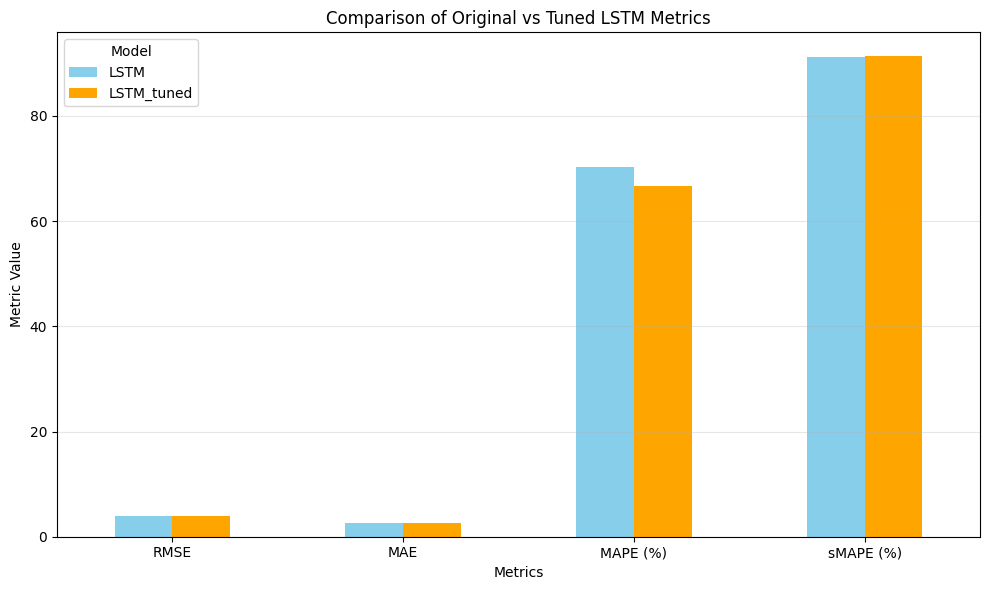

In [ ]:
# Set Model as index
comparison_df.set_index('Model', inplace=True)

# Transpose for plotting metrics on x-axis
plot_df = comparison_df.T

# Plot
ax = plot_df.plot(kind='bar', figsize=(10,6), color=['skyblue','orange'])
plt.title('Comparison of Original vs Tuned LSTM Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Metrics')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()

# Save figure (optional)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/LSTM_Metrics_Comparison.png", dpi=300)
plt.show()


In [ ]:
lstm_forecast_df_tuned.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/lstm_forecast_df_tuned.csv")

In [7]:
LSTM_forecast = pd.read_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/lstm_forecast_df_tuned.csv")

##Convert forecast → inventory inputs




In [8]:
LSTM_forecast

,Unnamed: 0,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,FOODS_2_021,2.900158,1.825716,1.161098,2.003636,2.211775,4.331207,2.234320,2.116209,1.600282,...,2.211775,4.331207,2.234320,2.116209,1.600282,1.161098,2.003636,2.211775,4.331207,2.234320
1,FOODS_2_128,2.138391,2.636715,2.433742,1.477168,2.812557,3.773326,1.506708,1.560114,2.503838,...,2.812557,3.773326,1.506708,1.560114,2.503838,2.433742,1.477168,2.812557,3.773326,1.506708
2,FOODS_2_152,2.280756,1.399965,1.903768,1.095375,1.498827,1.717514,2.063243,1.694901,1.447097,...,1.498827,1.717514,2.063243,1.694901,1.447097,1.903768,1.095375,1.498827,1.717514,2.063243
3,FOODS_2_164,2.540292,2.124364,2.522178,2.571461,3.163477,3.602289,2.003366,2.736323,2.668772,...,3.163477,3.602289,2.003366,2.736323,2.668772,2.522178,2.571461,3.163477,3.602289,2.003366
4,FOODS_2_181,7.503652,11.980584,8.134896,10.156574,12.127009,10.377631,8.634940,9.255320,12.393660,...,12.127009,10.377631,8.634940,9.255320,12.393660,8.134896,10.156574,12.127009,10.377631,8.634940
5,FOODS_2_233,3.245945,4.889234,5.010372,3.883060,3.486903,3.943935,4.411584,3.261064,4.603051,...,3.486903,3.943935,4.411584,3.261064,4.603051,5.010372,3.883060,3.486903,3.943935,4.411584
6,FOODS_2_276,3.546238,4.019461,4.494054,4.022763,3.379306,4.309574,6.282248,4.550645,4.093312,...,3.379306,4.309574,6.282248,4.550645,4.093312,4.494054,4.022763,3.379306,4.309574,6.282248
7,FOODS_2_360,7.405848,5.570976,4.446882,6.617374,7.592295,10.027728,7.094436,5.821740,5.131731,...,7.592295,10.027728,7.094436,5.821740,5.131731,4.446882,6.617374,7.592295,10.027728,7.094436
8,FOODS_2_364,0.976537,2.391314,2.068924,3.492000,2.608651,2.441307,1.521310,1.692121,2.643297,...,2.608651,2.441307,1.521310,1.692121,2.643297,2.068924,3.492000,2.608651,2.441307,1.521310
9,FOODS_2_398,4.582157,4.562231,5.246171,7.226217,5.618727,9.132146,6.022874,5.010542,5.051780,...,5.618727,9.132146,6.022874,5.010542,5.051780,5.246171,7.226217,5.618727,9.132146,6.022874


In [9]:
LSTM_forecast.rename(columns={'Unnamed: 0': 'item_id'}, inplace=True)
LSTM_forecast

,item_id,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,FOODS_2_021,2.900158,1.825716,1.161098,2.003636,2.211775,4.331207,2.234320,2.116209,1.600282,...,2.211775,4.331207,2.234320,2.116209,1.600282,1.161098,2.003636,2.211775,4.331207,2.234320
1,FOODS_2_128,2.138391,2.636715,2.433742,1.477168,2.812557,3.773326,1.506708,1.560114,2.503838,...,2.812557,3.773326,1.506708,1.560114,2.503838,2.433742,1.477168,2.812557,3.773326,1.506708
2,FOODS_2_152,2.280756,1.399965,1.903768,1.095375,1.498827,1.717514,2.063243,1.694901,1.447097,...,1.498827,1.717514,2.063243,1.694901,1.447097,1.903768,1.095375,1.498827,1.717514,2.063243
3,FOODS_2_164,2.540292,2.124364,2.522178,2.571461,3.163477,3.602289,2.003366,2.736323,2.668772,...,3.163477,3.602289,2.003366,2.736323,2.668772,2.522178,2.571461,3.163477,3.602289,2.003366
4,FOODS_2_181,7.503652,11.980584,8.134896,10.156574,12.127009,10.377631,8.634940,9.255320,12.393660,...,12.127009,10.377631,8.634940,9.255320,12.393660,8.134896,10.156574,12.127009,10.377631,8.634940
5,FOODS_2_233,3.245945,4.889234,5.010372,3.883060,3.486903,3.943935,4.411584,3.261064,4.603051,...,3.486903,3.943935,4.411584,3.261064,4.603051,5.010372,3.883060,3.486903,3.943935,4.411584
6,FOODS_2_276,3.546238,4.019461,4.494054,4.022763,3.379306,4.309574,6.282248,4.550645,4.093312,...,3.379306,4.309574,6.282248,4.550645,4.093312,4.494054,4.022763,3.379306,4.309574,6.282248
7,FOODS_2_360,7.405848,5.570976,4.446882,6.617374,7.592295,10.027728,7.094436,5.821740,5.131731,...,7.592295,10.027728,7.094436,5.821740,5.131731,4.446882,6.617374,7.592295,10.027728,7.094436
8,FOODS_2_364,0.976537,2.391314,2.068924,3.492000,2.608651,2.441307,1.521310,1.692121,2.643297,...,2.608651,2.441307,1.521310,1.692121,2.643297,2.068924,3.492000,2.608651,2.441307,1.521310
9,FOODS_2_398,4.582157,4.562231,5.246171,7.226217,5.618727,9.132146,6.022874,5.010542,5.051780,...,5.618727,9.132146,6.022874,5.010542,5.051780,5.246171,7.226217,5.618727,9.132146,6.022874


In [12]:
# Parameters

LEAD_TIME = 5             # lead time in days
HOLDING_COST = 0.1        # holding cost per unit per day
ORDER_COST = 50           # cost per order
SIMULATION_START = '2016-03-28'  # simulation start date
SIMULATION_END = '2016-04-24'    # simulation end date

# Prepare dataset

Sales_df['date'] = pd.to_datetime(Sales_df['date'])

# Filter simulation period
sim_df = Sales_df[(Sales_df['date'] >= SIMULATION_START) &
                  (Sales_df['date'] <= SIMULATION_END)].copy()


# Compute long-term mean demand per item

mean_demand = Sales_df.groupby('item_id')['sales'].mean().to_dict()

# Initialize inventory and orders
items = sim_df['item_id'].unique()
inventory = {item: mean_demand[item] * LEAD_TIME for item in items}  # initial inventory = ROP
ROP = {item: mean_demand[item] * LEAD_TIME for item in items}        # fixed ROP
order_qty = {item: mean_demand[item] * LEAD_TIME for item in items}  # order up to ROP
outstanding_orders = {item: [] for item in items}                     # track incoming orders

# Containers for KPI tracking
total_fulfilled = {item: 0 for item in items}
total_unfulfilled = {item: 0 for item in items}
holding_costs = {item: 0 for item in items}
ordering_costs = {item: 0 for item in items}
daily_inventory = {item: [] for item in items}


# Simulation loop

dates = pd.date_range(SIMULATION_START, SIMULATION_END)

for current_date in dates:
    day_sales = sim_df[sim_df['date'] == current_date]

    for item in items:
        demand = day_sales[day_sales['item_id'] == item]['sales'].sum()

        # Receive orders if lead time passed
        arriving_orders = [q for q, arrive_date in outstanding_orders[item] if arrive_date <= current_date]
        if arriving_orders:
            inventory[item] += sum(arriving_orders)
            outstanding_orders[item] = [x for x in outstanding_orders[item] if x[1] > current_date]

        # Fulfill demand
        fulfilled = min(demand, inventory[item])
        unfulfilled = max(0, demand - inventory[item])
        inventory[item] -= fulfilled

        # Track KPIs
        total_fulfilled[item] += fulfilled
        total_unfulfilled[item] += unfulfilled
        holding_costs[item] += inventory[item] * HOLDING_COST
        daily_inventory[item].append(inventory[item])

        # Check ROP and place order if needed
        if inventory[item] <= ROP[item]:
            qty = order_qty[item]
            arrive_date = current_date + pd.Timedelta(days=LEAD_TIME)
            outstanding_orders[item].append((qty, arrive_date))
            ordering_costs[item] += ORDER_COST


# Collect KPI rows in a list instead of appending

kpi_rows = []

for item in items:
    fulfilled = total_fulfilled[item]
    unfulfilled = total_unfulfilled[item]
    total_demand = fulfilled + unfulfilled
    avg_inventory = np.mean(daily_inventory[item])

    kpi_rows.append({
        'item_id': item,
        'Fill_Rate': fulfilled / total_demand if total_demand > 0 else np.nan,
        'Stockout_Rate': unfulfilled / total_demand if total_demand > 0 else np.nan,
        'Total_Cost': holding_costs[item] + ordering_costs[item],
        'Holding_Cost': holding_costs[item],
        'Ordering_Cost': ordering_costs[item],
        'Inventory_Turnover': fulfilled / avg_inventory if avg_inventory > 0 else np.nan
    })

# Create DataFrame at once
kpis_trad = pd.DataFrame(kpi_rows)
kpis_trad.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/kpis_trad.csv")
kpis_trad.head()


,item_id,Fill_Rate,Stockout_Rate,Total_Cost,Holding_Cost,Ordering_Cost,Inventory_Turnover
0,FOODS_2_021,1.000000,0.000000,643.647674,393.647674,250,1.237655
1,FOODS_2_128,1.000000,0.000000,585.224778,335.224778,250,1.712284
2,FOODS_2_152,1.000000,0.000000,534.744590,84.744590,450,3.535329
3,FOODS_2_164,1.000000,0.000000,615.823262,115.823262,500,3.843787
4,FOODS_2_181,0.882494,0.117506,847.112546,97.112546,750,9.541697


In [14]:

# Parameters

LEAD_TIME = 5             # days
HOLDING_COST = 0.1        # cost per unit per day
ORDER_COST = 50           # cost per order
SIMULATION_START = '2016-03-28'
SIMULATION_END = '2016-04-24'

# Prepare LSTM forecast dataframe

LSTM_forecast_long = LSTM_forecast.melt(
    id_vars='item_id',
    var_name='date',
    value_name='forecast'
)
LSTM_forecast_long['date'] = pd.to_datetime(LSTM_forecast_long['date'], dayfirst=True)

# Filter simulation period
LSTM_forecast_long = LSTM_forecast_long[
    (LSTM_forecast_long['date'] >= SIMULATION_START) &
    (LSTM_forecast_long['date'] <= SIMULATION_END)
]

# Merge with historical actual demand

Sales_df['date'] = pd.to_datetime(Sales_df['date'])
sim_df = Sales_df[
    (Sales_df['date'] >= SIMULATION_START) &
    (Sales_df['date'] <= SIMULATION_END)
][['item_id','date','sales']]

data = pd.merge(LSTM_forecast_long, sim_df, on=['item_id','date'], how='left')

# Initialize inventory & tracking

items = data['item_id'].unique()
inventory = {item: 0 for item in items}  # initial inventory can be 0 or forecast-based
outstanding_orders = {item: [] for item in items}

# Containers for KPI tracking
total_fulfilled = {item: 0 for item in items}
total_unfulfilled = {item: 0 for item in items}
holding_costs = {item: 0 for item in items}
ordering_costs = {item: 0 for item in items}
daily_inventory = {item: [] for item in items}


# Simulation loop

dates = pd.date_range(SIMULATION_START, SIMULATION_END)

for current_date in dates:
    day_data = data[data['date'] == current_date]

    for item in items:
        demand = day_data[day_data['item_id'] == item]['sales'].sum()
        forecast = day_data[day_data['item_id'] == item]['forecast'].values[0]

        # Receive orders if lead time passed
        arriving_orders = [q for q, arrive_date in outstanding_orders[item] if arrive_date <= current_date]
        if arriving_orders:
            inventory[item] += sum(arriving_orders)
            outstanding_orders[item] = [x for x in outstanding_orders[item] if x[1] > current_date]

        # Fulfill demand
        fulfilled = min(demand, inventory[item])
        unfulfilled = max(0, demand - inventory[item])
        inventory[item] -= fulfilled

        # Track KPIs
        total_fulfilled[item] += fulfilled
        total_unfulfilled[item] += unfulfilled
        holding_costs[item] += inventory[item] * HOLDING_COST
        daily_inventory[item].append(inventory[item])

        # Forecast-driven ROP / order quantity
        ROP = forecast * LEAD_TIME
        order_qty = forecast * LEAD_TIME

        if inventory[item] <= ROP:
            arrive_date = current_date + pd.Timedelta(days=LEAD_TIME)
            outstanding_orders[item].append((order_qty, arrive_date))
            ordering_costs[item] += ORDER_COST


# Compute KPIs

kpi_rows = []

for item in items:
    fulfilled = total_fulfilled[item]
    unfulfilled = total_unfulfilled[item]
    total_demand = fulfilled + unfulfilled
    avg_inventory = np.mean(daily_inventory[item])

    kpi_rows.append({
        'item_id': item,
        'Fill_Rate': fulfilled / total_demand if total_demand > 0 else np.nan,
        'Stockout_Rate': unfulfilled / total_demand if total_demand > 0 else np.nan,
        'Total_Cost': holding_costs[item] + ordering_costs[item],
        'Holding_Cost': holding_costs[item],
        'Ordering_Cost': ordering_costs[item],
        'Inventory_Turnover': fulfilled / avg_inventory if avg_inventory > 0 else np.nan
    })

kpis_LSTM_tuned = pd.DataFrame(kpi_rows)
kpis_LSTM_tuned.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/kpis_LSTM_tuned.csv")
# View KPIs

kpis_LSTM_tuned.head()


,item_id,Fill_Rate,Stockout_Rate,Total_Cost,Holding_Cost,Ordering_Cost,Inventory_Turnover
0,FOODS_2_021,0.600643,0.399357,792.502500,42.502500,750,6.885086
1,FOODS_2_128,0.816495,0.183505,835.855624,35.855624,800,13.070982
2,FOODS_2_152,0.792498,0.207502,730.432870,30.432870,700,7.801836
3,FOODS_2_164,0.781879,0.218121,757.749570,57.749570,700,6.027621
4,FOODS_2_181,0.889071,0.110929,799.624792,199.624792,600,4.676397


In [15]:
# Merge KPI DataFrames
comparison = pd.merge(
    kpis_trad,
    kpis_LSTM_tuned,
    on='item_id',
    suffixes=('_baseline', '_sarima')
)

# Select only relevant KPIs
kpi_cols = ['Fill_Rate', 'Stockout_Rate']

# Compute difference and percentage change for selected KPIs
for col in kpi_cols:
    comparison[f'{col}_diff'] = comparison[f'{col}_sarima'] - comparison[f'{col}_baseline']
    comparison[f'{col}_pct_change'] = (comparison[f'{col}_diff'] / comparison[f'{col}_baseline']) * 100

# Keep only relevant columns for readability
itemwise_comparison = comparison[['item_id'] +
                                 [f'{col}_baseline' for col in kpi_cols] +
                                 [f'{col}_sarima' for col in kpi_cols] +
                                 [f'{col}_diff' for col in kpi_cols] +
                                 [f'{col}_pct_change' for col in kpi_cols]]

# Display the first few rows
itemwise_comparison.head(50)


,item_id,Fill_Rate_baseline,Stockout_Rate_baseline,Fill_Rate_sarima,Stockout_Rate_sarima,Fill_Rate_diff,Stockout_Rate_diff,Fill_Rate_pct_change,Stockout_Rate_pct_change
0,FOODS_2_021,1.000000,0.000000,0.600643,0.399357,-0.399357,0.399357,-39.935682,inf
1,FOODS_2_128,1.000000,0.000000,0.816495,0.183505,-0.183505,0.183505,-18.350487,inf
2,FOODS_2_152,1.000000,0.000000,0.792498,0.207502,-0.207502,0.207502,-20.750248,inf
3,FOODS_2_164,1.000000,0.000000,0.781879,0.218121,-0.218121,0.218121,-21.812105,inf
4,FOODS_2_181,0.882494,0.117506,0.889071,0.110929,0.006577,-0.006577,0.745327,-5.597550
5,FOODS_2_233,0.752820,0.247180,0.862530,0.137470,0.109710,-0.109710,14.573151,-44.384581
6,FOODS_2_276,1.000000,0.000000,0.899810,0.100190,-0.100190,0.100190,-10.019027,inf
7,FOODS_2_360,0.989413,0.010587,0.779200,0.220800,-0.210213,0.210213,-21.246212,1985.627620
8,FOODS_2_364,1.000000,0.000000,0.848053,0.151947,-0.151947,0.151947,-15.194661,inf
9,FOODS_2_398,0.932273,0.067727,0.850192,0.149808,-0.082081,0.082081,-8.804376,121.193358


In [21]:
# Select the item FOODS_2_233
item_Service_Kpi = itemwise_comparison[itemwise_comparison['item_id'] == 'FOODS_2_233']

# Display the comparison
item_Service_Kpi.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/KPI_Comparison.csv')
item_Service_Kpi


,item_id,Fill_Rate_baseline,Stockout_Rate_baseline,Fill_Rate_sarima,Stockout_Rate_sarima,Fill_Rate_diff,Stockout_Rate_diff,Fill_Rate_pct_change,Stockout_Rate_pct_change
5,FOODS_2_233,0.75282,0.24718,0.86253,0.13747,0.10971,-0.10971,14.573151,-44.384581


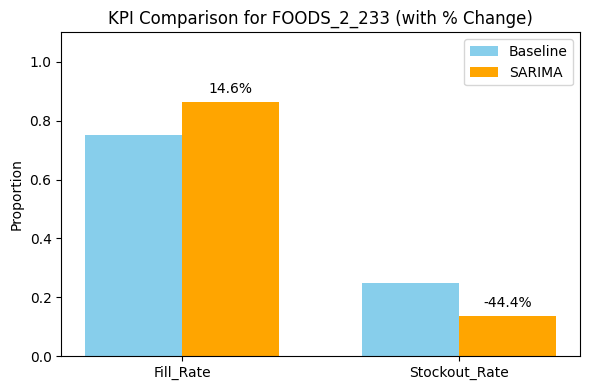

In [24]:
# Select the item
item_id = 'FOODS_2_233'
item_data = itemwise_comparison[itemwise_comparison['item_id'] == item_id]

# Prepare data
kpis = ['Fill_Rate', 'Stockout_Rate']
baseline_values = [item_data[f'{k}_baseline'].values[0] for k in kpis]
sarima_values = [item_data[f'{k}_sarima'].values[0] for k in kpis]
pct_changes = [item_data[f'{k}_pct_change'].values[0] for k in kpis]

x = range(len(kpis))
width = 0.35

plt.figure(figsize=(6,4))
bars1 = plt.bar(x, baseline_values, width=width, label='Baseline', color='skyblue')
bars2 = plt.bar([i + width for i in x], sarima_values, width=width, label='SARIMA', color='orange')

# Add percentage change on top of SARIMA bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    change_text = f'{pct_changes[i]:.1f}%'
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, change_text, ha='center', va='bottom', fontsize=10)

plt.xticks([i + width/2 for i in x], kpis)
plt.ylabel('Proportion')
plt.title(f'KPI Comparison for {item_id} (with % Change)')
plt.ylim(0, 1.1)  # slightly above 1 to leaving space for labels
plt.savefig('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/KPI_Comparison.png')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# List of all KPIs including cost/inventory
kpi_cols = ['Total_Cost', 'Holding_Cost', 'Ordering_Cost', 'Inventory_Turnover']

# Compute difference and percentage change for all KPIs
for col in kpi_cols:
    comparison[f'{col}_diff'] = comparison[f'{col}_sarima'] - comparison[f'{col}_baseline']
    comparison[f'{col}_pct_change'] = (comparison[f'{col}_diff'] / comparison[f'{col}_baseline']) * 100

# Now select the item FOODS_2_233
item_cost_kpis = comparison[comparison['item_id'] == 'FOODS_2_233']

# Select only cost-related columns
cols_to_show = ['item_id',
                'Total_Cost_baseline', 'Total_Cost_sarima', 'Total_Cost_diff', 'Total_Cost_pct_change',
                'Holding_Cost_baseline', 'Holding_Cost_sarima', 'Holding_Cost_diff', 'Holding_Cost_pct_change',
                'Ordering_Cost_baseline', 'Ordering_Cost_sarima', 'Ordering_Cost_diff', 'Ordering_Cost_pct_change',
                'Inventory_Turnover_baseline', 'Inventory_Turnover_sarima', 'Inventory_Turnover_diff', 'Inventory_Turnover_pct_change']

item_cost_kpis = item_cost_kpis[cols_to_show]

# Display
item_cost_kpis.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Cost_KPI_Comparison.csv')
item_cost_kpis


,item_id,Total_Cost_baseline,Total_Cost_sarima,Total_Cost_diff,Total_Cost_pct_change,Holding_Cost_baseline,Holding_Cost_sarima,Holding_Cost_diff,Holding_Cost_pct_change,Ordering_Cost_baseline,Ordering_Cost_sarima,Ordering_Cost_diff,Ordering_Cost_pct_change,Inventory_Turnover_baseline,Inventory_Turnover_sarima,Inventory_Turnover_diff,Inventory_Turnover_pct_change
5,FOODS_2_233,777.09838,742.39939,-34.69899,-4.465199,27.09838,92.39939,65.30101,240.977547,750,650,-100,-13.333333,13.379335,4.495641,-8.883694,-66.398623


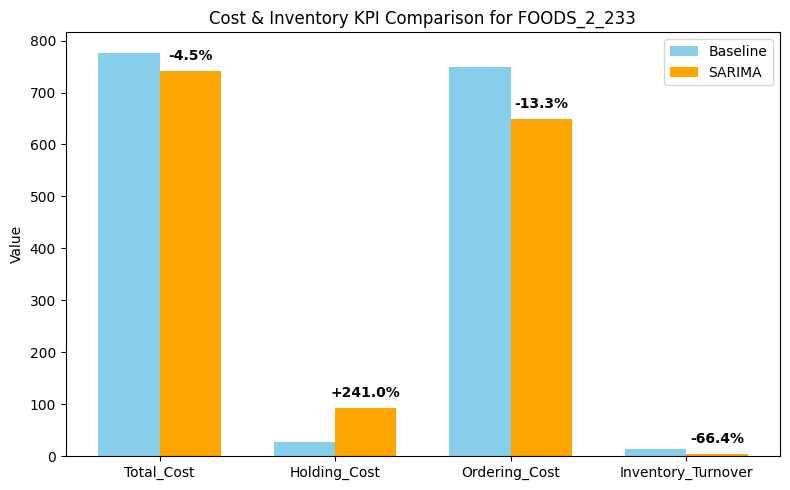

In [20]:
# KPI values for the item FOODS_2_233
item_data = item_cost_kpis.iloc[0]

kpis = ['Total_Cost', 'Holding_Cost', 'Ordering_Cost', 'Inventory_Turnover']
baseline_values = [item_data[f'{kpi}_baseline'] for kpi in kpis]
sarima_values = [item_data[f'{kpi}_sarima'] for kpi in kpis]
pct_changes = [item_data[f'{kpi}_pct_change'] for kpi in kpis]

x = np.arange(len(kpis))
width = 0.35

plt.figure(figsize=(8,5))
bars1 = plt.bar(x - width/2, baseline_values, width, label='Baseline', color='skyblue')
bars2 = plt.bar(x + width/2, sarima_values, width, label='SARIMA', color='orange')

# Annotate percentage change on top of SARIMA bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    # Format percentage with + or - sign
    sign = '+' if pct_changes[i] >= 0 else ''
    plt.text(bar.get_x() + bar.get_width()/2, height + max(sarima_values)*0.02,
             f'{sign}{pct_changes[i]:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(x, kpis)
plt.ylabel('Value')
plt.title(f'Cost & Inventory KPI Comparison for {item_data["item_id"]}')
plt.legend()
plt.savefig('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Cost & Inventory KPI Comparison.png')
plt.tight_layout()
plt.show()
